#### Face Identity Classification
This example illustrates MIA attacks on a face identity classfier model. The classfier is train on [CelebA Mask HQ](https://github.com/switchablenorms/CelebAMask-HQ) dataset which should be downloaded, decompressed, and placed in the ```data``` directory as follows:

directory_structure:

```
data/
    ├── train/
    │   ├── identity 1/
    │   ├── identity 2/
    │   └── ...
    └── test/
        ├── identity 1/
        ├── identity 2/
        └── ...
```


In [4]:
import os

# Path to the dataset zip file
zip_path = "./data/CelebA_HQ_facial_identity_dataset.zip"
data_folder = "./data"

# Check if the 'data' folder exists, if not, create it
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    print("'data' folder created.")

# Check if the file already exists
if not os.path.exists(zip_path):
    print("Dataset not found. Downloading...")
    !wget -O {zip_path} https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ES-jbCNC6mNHhCyR4Nl1QpYBlxVOJ5YiVerhDpzmoS9ezA?download=1 
    !unzip {zip_path} -d ./data
    print("Download and extraction completed.")
else:
    print("Dataset already exists.")

Dataset already exists.


### Train the Identity Classifier Model

In [5]:
import os
import sys
import yaml

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

In [6]:
from examples.mia.celebA_HQ.utils.celeb_hq_data import get_celebA_hq_dataloader
from examples.mia.celebA_HQ.utils.celeb_hq_model import ResNet18, create_trained_model_and_metadata

# Load the config.yaml file
with open('train_config.yaml', 'r') as file:
    train_config = yaml.safe_load(file)

# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), train_config["data"]["data_dir"])

In [7]:
train_loader, test_loader = get_celebA_hq_dataloader(path, train_config)

Load data from ./data/celeba_hq_data.pkl


In [8]:
from torch import cuda, device

device_name = device("cuda" if cuda.is_available() else "cpu")
print(device_name)

cuda


In [9]:
num_classes =307

model = ResNet18(num_classes = num_classes)
train_acc, train_loss, test_acc, test_loss = create_trained_model_and_metadata(model,train_loader,test_loader, train_config)

Training Progress: 100%|██████████| 30/30 [03:29<00:00,  6.99s/it]


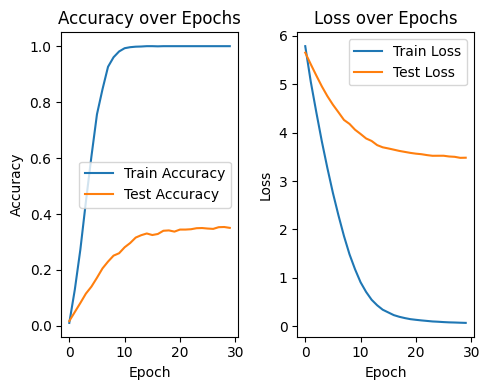

In [10]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### MIA Attacks on Identifier Model 

In [12]:
from celebA_HQ_handler import CelebAHQInputHandler

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(CelebAHQInputHandler, config_path)

# Run the audit 
mia_results = leakpro.run_audit(return_results=True)

2025-02-10 14:12:35,126 INFO     Target model blueprint created from ResNet18 in ./utils/celeb_hq_model.py.
2025-02-10 14:12:35,127 INFO     Loaded target model metadata from ./target/model_metadata.pkl


Configurations: {'audit': {'random_seed': 1234, 'attack_list': {'rmia': {'training_data_fraction': 0.5, 'attack_data_fraction': 0.5, 'num_shadow_models': 3, 'online': True, 'temperature': 2, 'gamma': 2.0, 'offline_a': 0.33, 'offline_b': 0.66}}, 'output_dir': './leakpro_output', 'attack_type': 'mia', 'modality': 'image'}, 'target': {'module_path': './utils/celeb_hq_model.py', 'model_class': 'ResNet18', 'target_folder': './target', 'data_path': './data/celeba_hq_data.pkl'}, 'shadow_model': None, 'distillation_model': None}


2025-02-10 14:12:35,388 INFO     Loaded target model from ./target
2025-02-10 14:12:40,804 INFO     Loaded population dataset from ./data/celeba_hq_data.pkl
2025-02-10 14:12:40,805 INFO     Loaded population dataset from ./data/celeba_hq_data.pkl
2025-02-10 14:12:40,956 INFO     MIA attack factory loaded.
2025-02-10 14:12:40,957 INFO     Creating shadow model handler singleton
2025-02-10 14:12:40,957 INFO     Created folder ./leakpro_output/attack_objects/shadow_model
2025-02-10 14:12:40,958 INFO     Creating distillation model handler singleton
2025-02-10 14:12:40,959 INFO     Created folder ./leakpro_output/attack_objects/distillation_model
2025-02-10 14:12:40,959 INFO     Configuring RMIA attack
2025-02-10 14:12:40,960 INFO     Added attack: rmia
2025-02-10 14:12:40,960 INFO     Preparing attack: rmia
2025-02-10 14:12:40,961 INFO     Preparing shadow models for RMIA attack
2025-02-10 14:12:40,961 INFO     Preparing attack data for training the RMIA attack
2025-02-10 14:12:40,968 INF

### Report Generating

In [13]:
# Import and initialize ReportHandler
from leakpro.reporting.report_handler import ReportHandler

# report_handler = ReportHandler()
report_handler = ReportHandler(report_dir="./leakpro_output/results")

# Save MIA resuls using report handler
for res in mia_results:
    report_handler.save_results(attack_name=res.attack_name, result_data=res, config=res.configs)

# # Create the report by compiling the latex text
report_handler.create_report()

2025-02-10 14:27:20,830 INFO     Initializing report handler...
2025-02-10 14:27:20,831 INFO     report_dir set to: ./leakpro_output/results
2025-02-10 14:27:20,831 INFO     Saving results for rmia
2025-02-10 14:27:33,721 INFO     No results of type GIAResults found.
2025-02-10 14:27:33,722 INFO     No results of type SinglingOutResults found.
2025-02-10 14:27:33,722 INFO     No results of type InferenceResults found.
2025-02-10 14:27:33,723 INFO     No results of type LinkabilityResults found.
2025-02-10 14:27:33,725 INFO     Could not compile PDF: Command '['which', 'pdflatex']' returned non-zero exit status 1.
2025-02-10 14:27:33,725 INFO     Make sure to install pdflatex with apt install texlive-latex-base


<Figure size 640x480 with 0 Axes>